## Imports
Here we will do our usual imports. I would recommend numpy, scipy, skimage, sklearn, pytorch, and matplotlib. If you wish to utilise pointcloud visualisation then you can do that as described in the handout via Open3D. We will want to import our PacMan_Helper module as well.

In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

## Load the training data: Positives and Negatives
In the handout zip file there is a directory which contains numerous patches extracted from sample images. These patches are labelled as either containing a sphere or not. You may wish to use these to train a classifier for sphere detection. This classifier can then be used later to detect spheres and move our camera towards them.

In [2]:
class PacmanDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        initialise data set
        :param root_dir: file path which contains 'positives' and 'negatives' 
        :param transform: the transformation operation to be applied to each image
        """
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []

        # load positives
        pos_dir = os.path.join(root_dir, 'positives')
        self.images += [os.path.join(pos_dir, file) for file in os.listdir(pos_dir)]
        self.labels += [1] * len(os.listdir(pos_dir))  # 1 for positives

        # load negatives
        neg_dir = os.path.join(root_dir, 'negatives')
        self.images += [os.path.join(neg_dir, file) for file in os.listdir(neg_dir)]
        self.labels += [0] * len(os.listdir(neg_dir))  # 0 for negatives

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        image = Image.open(image_path)

        if self.transform:
            image = self.transform(image)

        label = self.labels[idx]
        return image, label

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),  # convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # normalisation
])

In [4]:
transform_augmented = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # 随机水平翻转
    # 随机选择90, 180, 或270度中的一个进行旋转
    transforms.RandomChoice([
        transforms.RandomRotation([90, 90]),
        transforms.RandomRotation([180, 180]),
        transforms.RandomRotation([270, 270])
    ]),
    transforms.ToTensor(),              # 将图片转换为Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 标准化
])

In [5]:
# create data-set
dataset = PacmanDataset(root_dir='training_data/img', transform=transform_augmented)

train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

# create data loader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### Showing examples in data loader

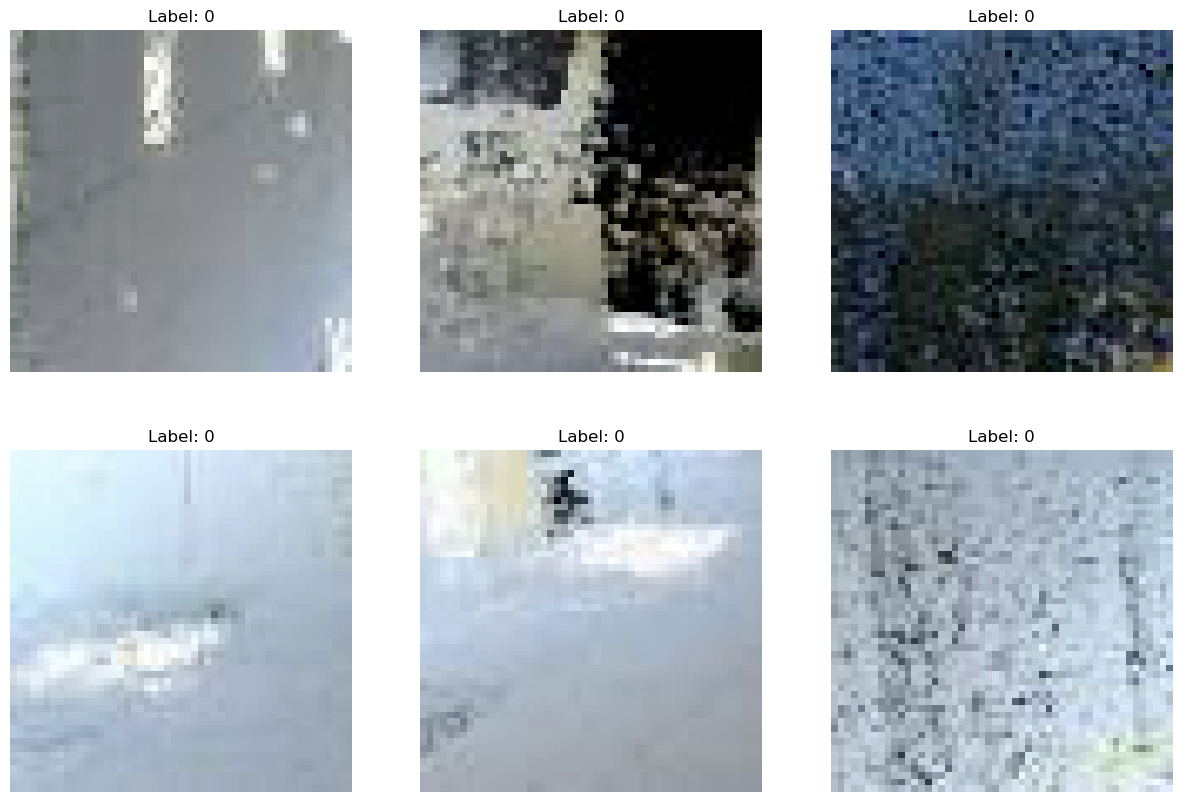

In [6]:
# get a batch size of data from data loader
images, labels = next(iter(train_loader))

# plot 6 examples in data loader
fig, axs = plt.subplots(2, 3, figsize=(15, 10))  # 创建一个2行3列的子图

for i, ax in enumerate(axs.flat):
    # convert tensor to numpy
    img = images[i].numpy().transpose((1, 2, 0))
    
    # denormalise images
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)

    # plot
    ax.imshow(img)
    ax.set_title(f'Label: {labels[i]}')
    ax.axis('off')

plt.show()

## Define the CNN Model

### Check GPU

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == 'cuda':
    gpu_name = torch.cuda.get_device_name(0)
    print(f'Using GPU: {gpu_name}')
else:
    print('CUDA is not available, using CPU.')

Using GPU: NVIDIA GeForce RTX 3070


### Create CNN Architecture

In [8]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # the 1st layer of convolution
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)  # output size: (16, 25, 25)

        # the 2nd layer of convolution
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2)  # output size: (32, 12, 12)

        # fully connected layer
        self.fc1 = nn.Linear(32 * 12 * 12, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()  # using sigmoid as activation function

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(-1, 32 * 12 * 12)  # flattening feature maps for fully connected layers
        x = self.relu3(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x

### Instantiate the model and send to GPU

In [9]:
model = SimpleCNN().to(device)
print(model)

SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4608, out_features=128, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


### Define the loss function and optimiser

In [10]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

### Define the training function

In [11]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    best_acc = 0.0
    for epoch in range(num_epochs):
        model.train()  # 设置模型为训练模式
        running_loss = 0.0
        running_corrects = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
            predictions = outputs > 0.5
            running_corrects += torch.sum(predictions == labels.data)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.float() / len(train_loader.dataset)
        print(f'Epoch {epoch+1}/{num_epochs} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # 在验证集上验证性能
        model.eval()  # 设置模型为评估模式
        val_loss = 0.0
        val_corrects = 0
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
            with torch.no_grad():
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                predictions = outputs > 0.5
                val_corrects += torch.sum(predictions == labels.data)
        
        val_loss = val_loss / len(val_loader.dataset)
        val_acc = val_corrects.float() / len(val_loader.dataset)
        print(f'Epoch {epoch+1}/{num_epochs} Validation Loss: {val_loss:.4f} Acc: {val_acc:.4f}')

        # 如果性能提高，保存最佳模型
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')

## Train the Network

In [12]:
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20)

Epoch 1/20 Train Loss: 0.0782 Acc: 0.9705
Epoch 1/20 Validation Loss: 0.0005 Acc: 1.0000
Epoch 2/20 Train Loss: 0.0009 Acc: 1.0000
Epoch 2/20 Validation Loss: 0.0016 Acc: 1.0000
Epoch 3/20 Train Loss: 0.0008 Acc: 0.9995
Epoch 3/20 Validation Loss: 0.0001 Acc: 1.0000
Epoch 4/20 Train Loss: 0.0001 Acc: 1.0000
Epoch 4/20 Validation Loss: 0.0000 Acc: 1.0000
Epoch 5/20 Train Loss: 0.0000 Acc: 1.0000
Epoch 5/20 Validation Loss: 0.0000 Acc: 1.0000
Epoch 6/20 Train Loss: 0.0000 Acc: 1.0000
Epoch 6/20 Validation Loss: 0.0000 Acc: 1.0000
Epoch 7/20 Train Loss: 0.0000 Acc: 1.0000
Epoch 7/20 Validation Loss: 0.0000 Acc: 1.0000
Epoch 8/20 Train Loss: 0.0000 Acc: 1.0000
Epoch 8/20 Validation Loss: 0.0000 Acc: 1.0000
Epoch 9/20 Train Loss: 0.0000 Acc: 1.0000
Epoch 9/20 Validation Loss: 0.0000 Acc: 1.0000
Epoch 10/20 Train Loss: 0.0000 Acc: 1.0000
Epoch 10/20 Validation Loss: 0.0000 Acc: 1.0000
Epoch 11/20 Train Loss: 0.0000 Acc: 1.0000
Epoch 11/20 Validation Loss: 0.0000 Acc: 1.0000
Epoch 12/20 Train

## 7. Save the Model
Save the trained model for future use.

## 8.Test the Model
Evaluate the model's performance on the test dataset.

In [13]:
def evaluate_model(model, test_loader):
    model.eval()  # 设置模型为评估模式
    all_labels = []
    all_predictions = []
    all_outputs = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
            outputs = model(images)
            predicted_probs = torch.sigmoid(outputs)
            predicted_labels = predicted_probs > 0.5
            all_labels.extend(labels.view(-1).tolist())
            all_predictions.extend(predicted_labels.view(-1).tolist())
            all_outputs.extend(predicted_probs.view(-1).tolist())

    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions)
    return all_labels, all_predictions, all_outputs, accuracy, precision, recall, f1

In [14]:
# 调用测试函数
labels, predictions, outputs, acc, prec, rec, f1 = evaluate_model(model, test_loader)

# 打印性能指标
print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1 Score: {f1:.4f}")

Accuracy: 0.9771, Precision: 0.8485, Recall: 1.0000, F1 Score: 0.9180


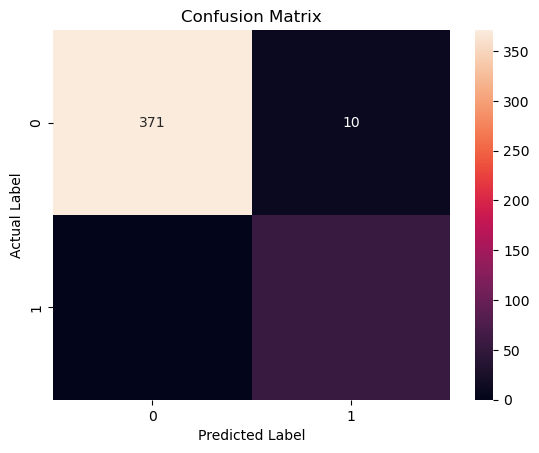

In [15]:
# 绘制混淆矩阵
cm = confusion_matrix(labels, predictions)
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

In [20]:
# 可视化一些测试图片及其预测结果
def visualize_predictions(images, labels, predictions, outputs):
    plt.figure(figsize=(10, 10))
    for i in range(6):  # 假定我们只展示6张图像
        plt.subplot(3, 3, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        
        img = images[i].numpy().transpose((1, 2, 0))  # 转换通道顺序
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean  # 反归一化
        img = np.clip(img, 0, 1)  # 限制数据范围在[0, 1]

        plt.imshow(img, cmap=plt.cm.binary)
        actual_label = labels[i].item()  # 获取实际标签的标量值
        predicted_label = int(predictions[i].item())  # 获取预测标签的整数值
        predicted_prob = outputs[i].item()  # 获取预测概率的标量值
        plt.xlabel(f"Actual: {actual_label},\nPredicted: {predicted_label},\nProb: {predicted_prob:.2f}")
    plt.tight_layout()
    plt.show()

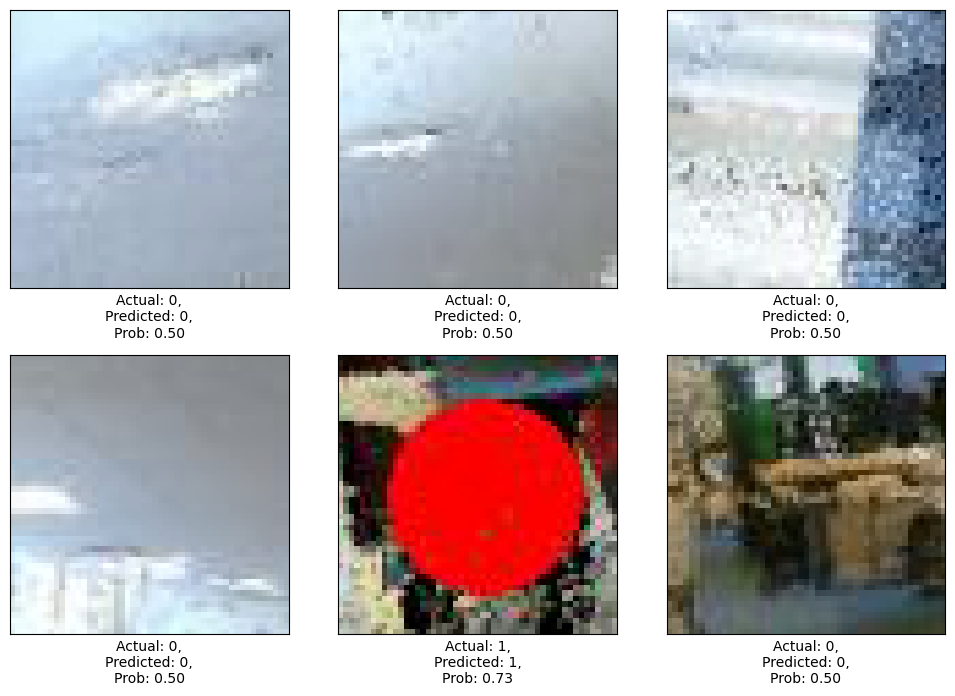

In [21]:
# 获取一批测试图片
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)
model.eval()
with torch.no_grad():
    outputs = model(images)
    predicted_probs = torch.sigmoid(outputs)
    predicted_labels = predicted_probs > 0.5

# 可视化预测结果
visualize_predictions(images.cpu(), labels.cpu().numpy(), predicted_labels.cpu().numpy(), predicted_probs.cpu().numpy())